# CVAE


In [ ]:
!pip install keras==2.0 -q 
!pip install tensorflow==1.13.2 -q -q  

     |████████████████████████████████| 191 kB 5.0 MB/s 
     |████████████████████████████████| 495.0 MB 25 kB/s 
     |████████████████████████████████| 489.6 MB 24 kB/s 
     |████████████████████████████████| 463.8 MB 33 kB/s 
     |████████████████████████████████| 462 kB 63.9 MB/s 
     |████████████████████████████████| 132 kB 67.6 MB/s 
     |████████████████████████████████| 14.8 MB 37.4 MB/s 
     |████████████████████████████████| 5.6 MB 40.9 MB/s 
     |████████████████████████████████| 458.3 MB 12 kB/s 
     |████████████████████████████████| 458.3 MB 13 kB/s 
     |████████████████████████████████| 458.3 MB 12 kB/s 
     |████████████████████████████████| 460.3 MB 8.4 kB/s 
     |████████████████████████████████| 462 kB 49.1 MB/s 
     |████████████████████████████████| 4.0 MB 44.8 MB/s 
     |████████████████████████████████| 1.2 MB 50.1 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the 

In [ ]:
import sys # модуль содержит параметры и функции, которые относятся к Python и его среде
import numpy as np # загружаем библиотеку для работы с массивами данных
import matplotlib.pyplot as plt # из библиотеки для визуализации данных возьмём интерфейс для построения графиков простых функций
%matplotlib inline
from scipy.stats import norm # модуль с нормальными непрерывными случайными величинами
# import seaborn as sns

from tensorflow.keras.datasets import mnist, fashion_mnist # загружаем готовую стандартную базу рукописных цифр mnist
from tensorflow.keras.utils import to_categorical # загружаем утилиты кераса для one-hot кодировки
from tensorflow.keras.layers import Input, Dense # загружаем необходимые слои(входной, полносвязный)
from tensorflow.keras.layers import BatchNormalization, Dropout, Flatten, Reshape, Lambda # загружаем слои(нормализации, регуляризации и т.д)
from tensorflow.keras.layers import concatenate, LeakyReLU # подгружаем слой конкатенации
from tensorflow.keras.models import Model # загружаем абстрактный класс базовой модели сети от кераса 
from tensorflow.keras.losses import binary_crossentropy # импортируем функцию потерь # импортируем функцию потерь
from tensorflow.keras import backend as K # устанавливаем переменную для окружения кераса
from tensorflow.keras.optimizers import Adam, RMSprop # загружаем выбранные оптимизаторы
from IPython.display import clear_output # импортируем модуль очистки output'а ячейки
from tensorflow.keras.callbacks import LambdaCallback, ReduceLROnPlateau, TensorBoard # импортируем коллбэки

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

In [ ]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()


x_train = x_train.astype('float32') / 255. 
x_test  = x_test .astype('float32') / 255. 
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1)) 
x_test  = np.reshape(x_test,  (len(x_test),  28, 28, 1)) 

y_train_cat = to_categorical(y_train, 10).astype(np.float32)
y_test_cat  = to_categorical(y_test, 10).astype(np.float32)
num_classes = y_test_cat.shape[1] 

4423680/4422102 [==============================] - 0s 0us/step


In [ ]:
batch_size = 500 # размер батча
latent_dim = 8 # размер скрытого слоя/пространства
dropout_rate = 0.3 # размер слоя регуляризации, "выключим" указанное количество нейронов, во избежание переобучения
start_lr = 0.001 # шаг обучения

In [ ]:
def create_cvae(): # объявляем функцию создания вариационного автокодировщика c условием
    models = {} # задаем словарь моделей

    # Добавим Dropout и BatchNormalization
    def apply_bn_and_dropout(x): # функция будет принимать на вход слой x
        return Dropout(dropout_rate)(BatchNormalization()(x)) # и применять к нему регуляризацию/нормализацию

    # Энкодер
    input_img = Input(shape=(28, 28, 1)) # размерности строк, столбцов, фильтров одной картинки
    flatten_img = Flatten()(input_img) # добавляем слой выравнивания/сглаживания ("сплющиваем" данные в вектор)
    input_lbl = Input(shape=(num_classes,), dtype='float32') # второй вход в энкодер с учетом лейблов и по количеству классов

    x = concatenate([flatten_img, input_lbl]) # конкатенируем входы сглаженной входной картинки и input_lbl
    
    x = Dense(256, activation='relu')(x) # полносвязный слой на 256 нейронов
    
    x = apply_bn_and_dropout(x) # применяем функцию добавления регуляризации/нормализации
    
    # Предсказываем параметры распределений
    
    # Вместо того чтобы предсказывать стандартное отклонение, предсказываем логарифм вариации
    z_mean = Dense(latent_dim)(x) # скрытое пространство(мат.ожидание) размером 8
    z_log_var = Dense(latent_dim)(x) # скрытое пространство(лог.вариации) размером 8

    # Сэмплирование из Q с трюком репараметризации
    def sampling(args): # обьявляем функцию сэмплирования
        z_mean, z_log_var = args # принимаем в аргументах z_mean, z_log_var, раскусываем их
        # керасовским методом делаем нормальное распределение(500 8мерных), мат.ожидание 0, ст.отклонение 1
        epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=1.0)
        return z_mean + K.exp(z_log_var / 2) * epsilon

    # задаем самописный слой, к-й принимает лист [z_mean, z_log_var], семплирует, и на выходе выдает размерность (8,)
    l = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var]) 

    models["encoder"]  = Model([input_img, input_lbl], l) # модель энкодера от входов до лямбда слоя
    models["z_meaner"] = Model([input_img, input_lbl], z_mean) # отдельная модель с путем от входов до z_mean
    models["z_lvarer"] = Model([input_img, input_lbl], z_log_var) # отдельная модель с путем от входов до z_log_var

    # Декодер
    z = Input(shape=(latent_dim, )) # задаем первую входную размерность (8,)
    input_lbl_d = Input(shape=(num_classes,), dtype='float32') # задаем вторую входную размерность по номеру классов
    x = concatenate([z, input_lbl_d]) # конкатенируем входы
    x = Dense(256)(x) # полносвязный слой на 256 нейронов
    x = LeakyReLU()(x) # применяем функцию активации отдельным слоем
    x = Dense(28*28, activation='sigmoid')(x) # полносвязный слой на 784 нейрона
    decoded = Reshape((28, 28, 1))(x) # меняем форму, приводим к нужным нам размерам

    models["decoder"] = Model([z, input_lbl_d], decoded, name='Decoder') # собираем модель декодера
    
    # Cобираем вариационный автокодировщик с условием(3 инпута на входе, затем первые два проходят через энкодер,
    # складываются с input_lbl_d и всё это проходит через декодер на выходе)
    models["cvae"]    = Model([input_img, input_lbl, input_lbl_d], 
                              models["decoder"]([models["encoder"]([input_img, input_lbl]), input_lbl_d]), 
                              name="CVAE")
    # Та же операция, но вместо энкодера модель z_meaner
    models["style_t"] = Model( [input_img, input_lbl, input_lbl_d] , 
                               models["decoder"] ( [models["z_meaner"]([input_img, input_lbl]), input_lbl_d] ) , 
                               name="style_transfer")
    
    
    def vae_loss(x, decoded): # объявляем самописную функцию потерь
        x = K.reshape(x, shape=(batch_size, 28*28)) # меняем размеры(в одномерный) x через керасовскую функцию
        decoded = K.reshape(decoded, shape=(batch_size, 28*28)) # меняем размеры(в одномерный) decoded через керасовскую функцию
        xent_loss = 28*28*binary_crossentropy(x, decoded) # берем бинарную кроссэнтропию между x и decoded, с учетом пикселей
        kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1) # по формуле устанавливаем ошибку kl_loss
        return (xent_loss + kl_loss)/2/28/28 # функция вернет суммарную ошибку с учетом распределения и размеров пикселей

    return models, vae_loss

models, vae_loss = create_cvae() # получаем модели и свою функцию потерь
cvae = models["cvae"] # задаем модель вариационного автокодировщика с условием
cvae.compile(optimizer = Adam(start_lr), loss=vae_loss)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [ ]:
cvae.compile(optimizer = Adam(start_lr), loss=vae_loss) # компилируем модель с выбранным оптимайзером и своей функцией потерь

In [ ]:
digit_size = 28 # задаем размеры цифр
def plot_digits(*args, invert_colors=False): # функция отрисует две линии картинок - оригинальные и выходные из автокодировщика
    args = [x.squeeze() for x in args] # удаляем оси с одним элементом из аргументов
    n = min([x.shape[0] for x in args]) # берем минимальное от нулевой оси x'ов в аргументах
    figure = np.zeros((digit_size * len(args), digit_size * n)) # создаем фигуру с использованием массива нулей по заданным размерам

    for i in range(n):
        for j in range(len(args)): # заполняем фигуру значениями
            figure[j * digit_size: (j + 1) * digit_size,
                   i * digit_size: (i + 1) * digit_size] = args[j][i].squeeze()

    if invert_colors: # если значение invert_colors будет True
        figure = 1-figure # то фигуру делаем обратной

    plt.figure(figsize=(2*n, 2*len(args))) # плотим фигуру с заданными значениями
    plt.imshow(figure, cmap='Greys_r') # выведем ее на экран в указанных цветах
    plt.grid(False) # указываем, что сетка не нужна
    ax = plt.gca() # получаем текущий объект Axes
    ax.get_xaxis().set_visible(False) # ось координат xaxis делаем невидимой
    ax.get_yaxis().set_visible(False) # ось координат yaxis делаем невидимой
    plt.show() # выводим отрисованное на экран


n = 15 # Картинка с 15x15 цифр


## Обучение

In [ ]:
# Эпохи, в которые будем сохранять
save_epochs = set([i*5 for i in range(0,25)])

# Отслеживать будем на вот этих цифрах
imgs = x_test[:batch_size]
imgs_lbls = y_test_cat[:batch_size]
n_compare = 10

# Модели
generator      = models["decoder"]
encoder_mean   = models["z_meaner"]


# Функция, которую будем запускать после каждой эпохи
def on_epoch_end(epoch, logs):
    if epoch in save_epochs:
        clear_output() # Не захламляем output

        # Сравнение реальных и декодированных цифр
        decoded = cvae.predict([imgs, imgs_lbls, imgs_lbls], batch_size=batch_size)
        plot_digits(imgs[:n_compare], decoded[:n_compare])



# Коллбэки
pltfig = LambdaCallback(on_epoch_end=on_epoch_end)
# lr_red = ReduceLROnPlateau(factor=0.1, patience=25)
tb     = TensorBoard(log_dir='./logs')

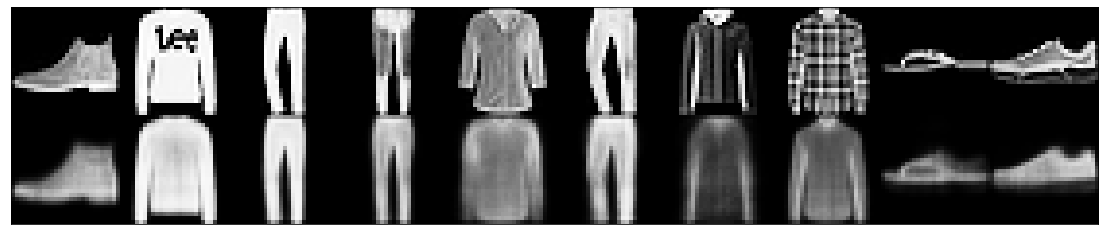

60000/60000 [==============================] - 12s 199us/sample - loss: 0.1585 - val_loss: 0.1580
Epoch 17/20
60000/60000 [==============================] - 12s 199us/sample - loss: 0.1582 - val_loss: 0.1577
Epoch 18/20
60000/60000 [==============================] - 12s 199us/sample - loss: 0.1579 - val_loss: 0.1576
Epoch 19/20
60000/60000 [==============================] - 12s 199us/sample - loss: 0.1578 - val_loss: 0.1574
Epoch 20/20
60000/60000 [==============================] - 14s 227us/sample - loss: 0.1575 - val_loss: 0.1573


In [ ]:
# Запуск обучения 
cvae.fit([x_train, y_train_cat, y_train_cat], x_train, shuffle=True, epochs=20,
         batch_size=batch_size,
         validation_data=([x_test, y_test_cat, y_test_cat], x_test),
         callbacks=[pltfig, tb],
         verbose=1) # грузим наши данные в модель, задаем параметры и обучаем

## Результат обучения



In [ ]:
def style_transfer(model, X, lbl_in, lbl_out): # объявляем функцию переноса стилей
    rows = X.shape[0] 
    if isinstance(lbl_in, int): # заполняем входные лейблы(энкодера)
        lbl = lbl_in 
        lbl_in = np.zeros((rows, 10)) # построчное заполнение нулями от 0 до 9
        lbl_in[:, lbl] = 1 # заполняем в нужную строчку единицу
    if isinstance(lbl_out, int): # заполняем выходные лейблы(декодера)
        lbl = lbl_out
        lbl_out = np.zeros((rows, 10)) # построчное заполнение нулями от 0 до 9
        lbl_out[:, lbl] = 1 # заполняем в нужную строчку единицу
    #print(lbl_in)
    #print(lbl_out)
    return model.predict([X, lbl_in, lbl_out]) # функция вернет предсказанные картинки

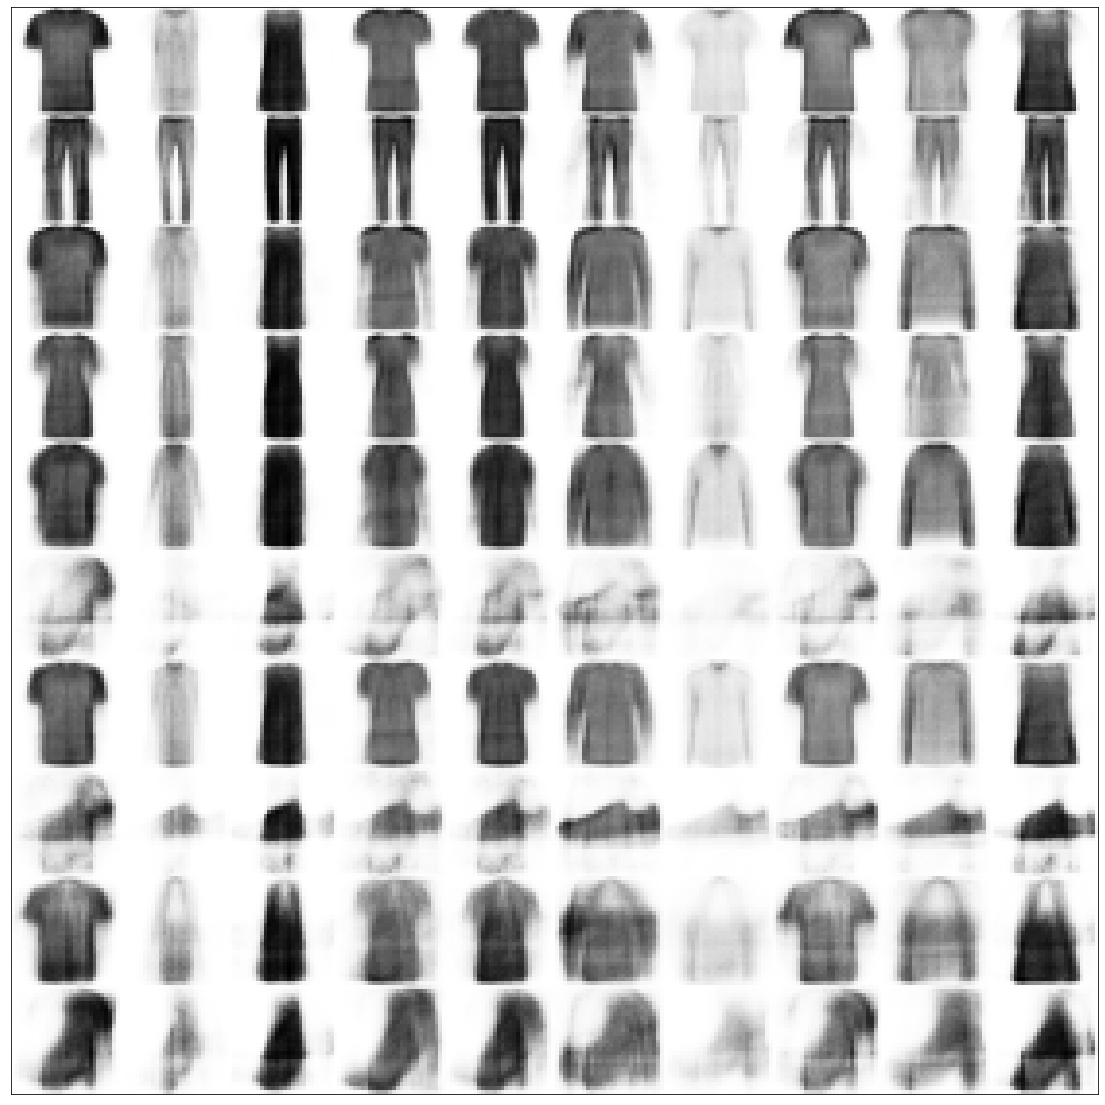

In [ ]:
n = 10 # выбираем количество картинок
lbl = 0 # выбираем лейбл
generated = [] # здесь соберем список сгенерированных картинок
prot = x_train[y_train == lbl][:n] # возьмем prot в качестве x с соответствующим выбранному значению лейбла 

for i in range(num_classes): # идем по каждому классу
    generated.append(style_transfer(models["style_t"], prot, lbl, i)) # и генерим картинки с учетом переноса стиля

#generated[lbl] = prot
plot_digits(*generated, invert_colors=True) # отрисовываем картинки